This a brief tutorial to use HDP-GPC, a dynamic clustering library. 
As a summary of the objectives of this notebook:
1. Learn to load some public data and learn how compute the initial statistics.
2. Learn to define the model and check each one of the hyperparameters' configuration.
3. Learn to execute inference and how this can be tuned.
4. Learn how to plot the results and study the dynamic parameters.

We should first import the main packages to deal with the data:

In [1]:
import numpy as np
import torch
import os

Now we can load the data, to illustrate this example we are going to reduce the data to examples from 1700 to 1950.

In [5]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean')
data = np.load(os.path.join(data_path, 'data.npy'))
freq = np.load(os.path.join(data_path, 'freq.npy'))
#labels = np.load(os.path.join(data_path, '100_labels.npy'))

print("Shape of the data: ")
print(data.shape)
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(14376, 171, 1)


The data dimensions correspond with [number of examples, number of observations, number of outputs]. Let's check how looks this data:

(171,)


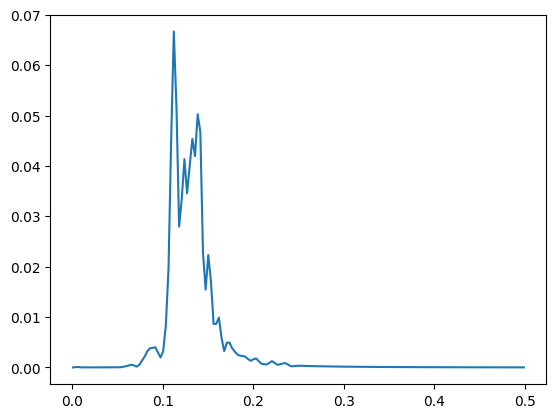

In [11]:
import matplotlib.pyplot as plt
print(freq.shape)
plt.plot(freq, data[0,:,0])
plt.show()

As we can see, it corresponds to a heartbeat. This is the kind of patterns we want to cluster over the record.
To compute the initial statistics we are going to use the observation variance and the 1-step rolled variance.
For that, we have a method in the get_data class, where we can choose the batch to compute this statistics.

In [ ]:
from hdpgpc.get_data import compute_estimators_LDS

std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=50)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 1e-2
std_dif = std_dif * 1e-2
bound_sigma = (std * 1e-2, std * 1.0)
bound_gamma = (std_dif * 1e-2, std_dif * 1.0)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)


As we can see, the 1-step variance is higher than the variance, which indicates a slight dynamic behaviour.

Now we can define the HDP-GPC model. 

The hyperparameters can be directly estimated from the previously computed estimators. As a standard an initial M has to be chosen, as a default, it is chosen as M=2 as the model computes the needed number of clusters as it progresses in the inference.


In [ ]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M

We can also define the kernel parameters, in this case we are taking outputscale = 300.0 as is the mean amplitude found on a standard record of ECG. Also, we are choosing ini_legthscale = 1.0 as a standard value. Both can be tuned, but they do not have a critical impact on the inference because they are optimized in terms of Maximum-Likelihood.

In [ ]:
outputscale_ = 0.1
ini_lengthscale = 1e-4
bound_lengthscale = (1e-7, 1e-3)

Also, we have to define the time indexes where the observations had been taken, which is x_train. In this case it can be as simple as a range of the same length of the observations, but it can differ along the samples. On the other hand, we have to define x_basis, which is the time index basis where the LDS is going to be computed (it fix the dimension of the LDS) If desired, the x_basis can be reduced to be a set of inducing points. If this dimensional reduction is applied it should be reflected in the option parameter inducing_points=True. 

In [ ]:
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq).T
x_train = np.atleast_2d(freq).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False

Additionally, we can also define the warp GP hyperparameters and time indexes. 

In [ ]:
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

Finally, with these parameters we can define the HDP-GPC. 
There exist a lot of configuration parameters that can be combined in this model, to check the options and the relevance of these configuration options go to the Documentation (in progress).

In terms of define the model, we should consider the inference method we want to apply because each one have their restrictions (by now).

1. In first place we have the online inference, where we can include one sample at a time and let the model cluster it. By now, the online inference only works with one output signal, but it is going to be extended soon. That's why we choose n_outputs=1.

In [ ]:
import hdpgpc.GPI_HDP as hdpgp

sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, estimation_limit=30)

We can revise the priors that had been defined for our model.  The cluster list of GP-LDS is generated inside the model, indexes as gpmodels[n_output][n_cluster]. We can plot the zero-knowledge cluster.

In [ ]:
sw_gp.gpmodels[0][0].plot_last(0)

In [ ]:
data_ = data[:,:,[0]]
sw_gp.include_sample(x_train, data_[0], with_warp=warp)

Now the first example has been included in the model. 
We can check some parameters to be sure the sample has been added:

In [ ]:
print("Kernel estimated:", sw_gp.gpmodels[0][0].gp.kernel)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
labels = np.array(['N'] * data.shape[0])
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, labels, main_model, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True)

As we can see, the sample had been added successfully and the GP performed regression over it. Now we can include more samples, in this case, we are adding 100 to check how fast is the computation without warp component.

In [13]:
import time

for j, d in enumerate(data_[1:10]):
    start_time = time.time()
    print("Sample:", j+1, "/", str(data_.shape[0]-1), "label:", labels[j+1])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

Sample: 1 / 249 label: N
Main model chosen: 1
Time --- 3.0687897205352783 seconds ---
Sample: 2 / 249 label: N
Main model chosen: 1
Time --- 0.12367582321166992 seconds ---
Sample: 3 / 249 label: N
Main model chosen: 1
Time --- 0.04786396026611328 seconds ---
Sample: 4 / 249 label: N
Main model chosen: 1
Time --- 0.09275317192077637 seconds ---
Sample: 5 / 249 label: N
Birth of new model:  2
Main model chosen: 2

 Fitting_GP: 

Iter 1/4000 - Loss: 922.443
Iter 501/4000 - Loss: 49.403
Iter 1001/4000 - Loss: 35.440
Iter 1501/4000 - Loss: 28.794
Iter 2001/4000 - Loss: 24.626
Iter 2501/4000 - Loss: 21.656
Iter 3001/4000 - Loss: 19.378
Iter 3501/4000 - Loss: 17.544


Parameter name: likelihood.noise_covar.raw_noise           value = [4.77047423]
Parameter name: mean_module.raw_constant                   value = -1.361558100298496
Parameter name: covar_module.raw_outputscale               value = 39.334739937806894
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[2.617171

The clustering has generated a bunch of clusters. Let's revise them using the util_plot methods. Here the difference between groups is clearer:

Model 1 : MainModel: N : [A-2,N-133]
Model 2 : MainModel: N : [N-65]
Model 3  : []
Classification error:  2.0 / 200 -- 0.01


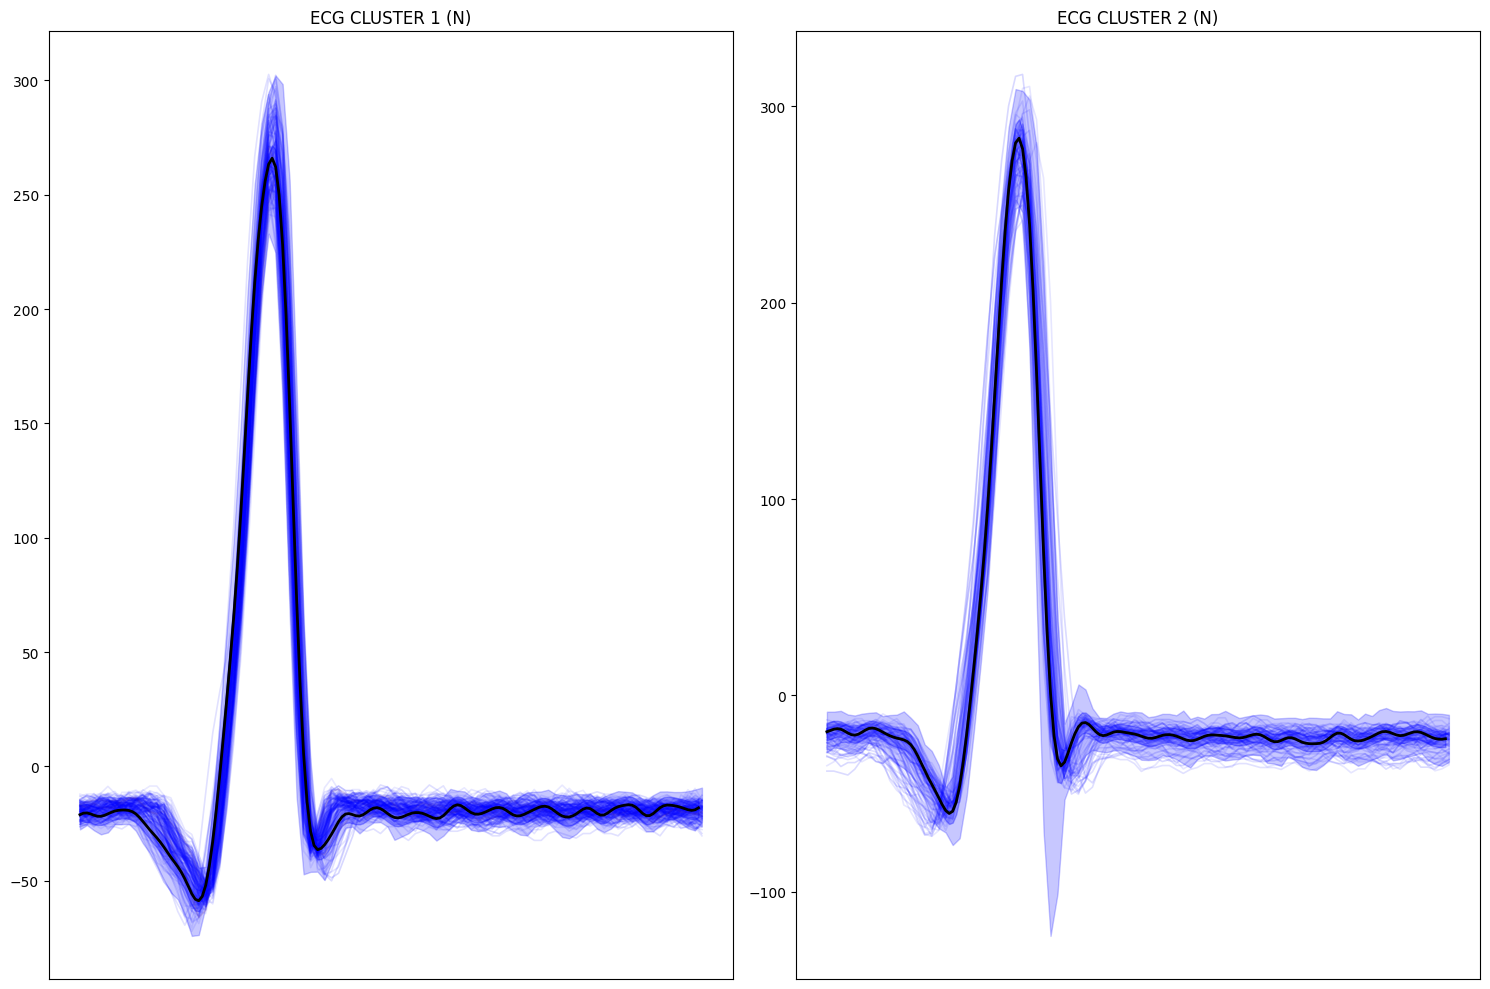

In [15]:
from hdpgpc.util_plots import print_results, plot_models_plotly

main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

If we try to include the examples from 1900 to 1950, knowing that a ventricular beat exist among them, we are going to check if the model generates a new group.

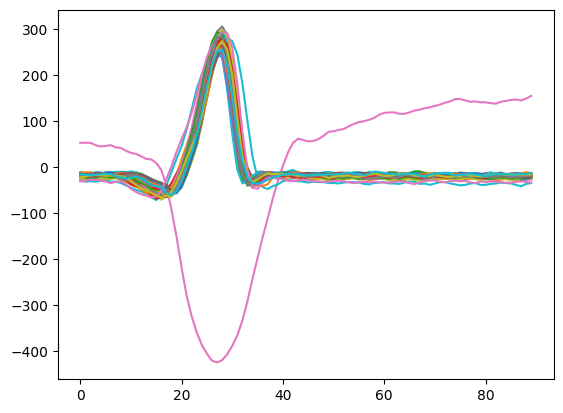

In [16]:
plt.plot(data_[200:,:,0].T)
plt.show()


In [17]:

for j, d in enumerate(data_[200:]):
    start_time = time.time()
    print("Sample:", j + 200, "/", str(data_.shape[0]-1), "label:", labels[j+200])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

Sample: 200 / 249 label: N
Main model chosen: 2
Time --- 0.10571694374084473 seconds ---
Sample: 201 / 249 label: N
Main model chosen: 2
Time --- 0.12767362594604492 seconds ---
Sample: 202 / 249 label: N
Main model chosen: 2
Time --- 0.13563776016235352 seconds ---
Sample: 203 / 249 label: N
Main model chosen: 2
Time --- 0.13663578033447266 seconds ---
Sample: 204 / 249 label: N
Main model chosen: 2
Time --- 0.10471749305725098 seconds ---
Sample: 205 / 249 label: N
Main model chosen: 2
Time --- 0.11469364166259766 seconds ---
Sample: 206 / 249 label: V
Birth of new model:  3
Main model chosen: 3

 Fitting_GP: 

Iter 1/4000 - Loss: 5166.897
Iter 501/4000 - Loss: 168.904
Iter 1001/4000 - Loss: 122.190
Iter 1501/4000 - Loss: 99.277
Iter 2001/4000 - Loss: 84.731
Iter 2501/4000 - Loss: 74.297
Iter 3001/4000 - Loss: 66.247
Iter 3501/4000 - Loss: 59.733


Parameter name: likelihood.noise_covar.raw_noise           value = [4.87867842]
Parameter name: mean_module.raw_constant                 

Model 1 : MainModel: N : [A-2,N-152]
Model 2 : MainModel: N : [N-95]
Model 3 : MainModel: V : [V-1]
Model 4  : []
Classification error:  2.0 / 250 -- 0.008


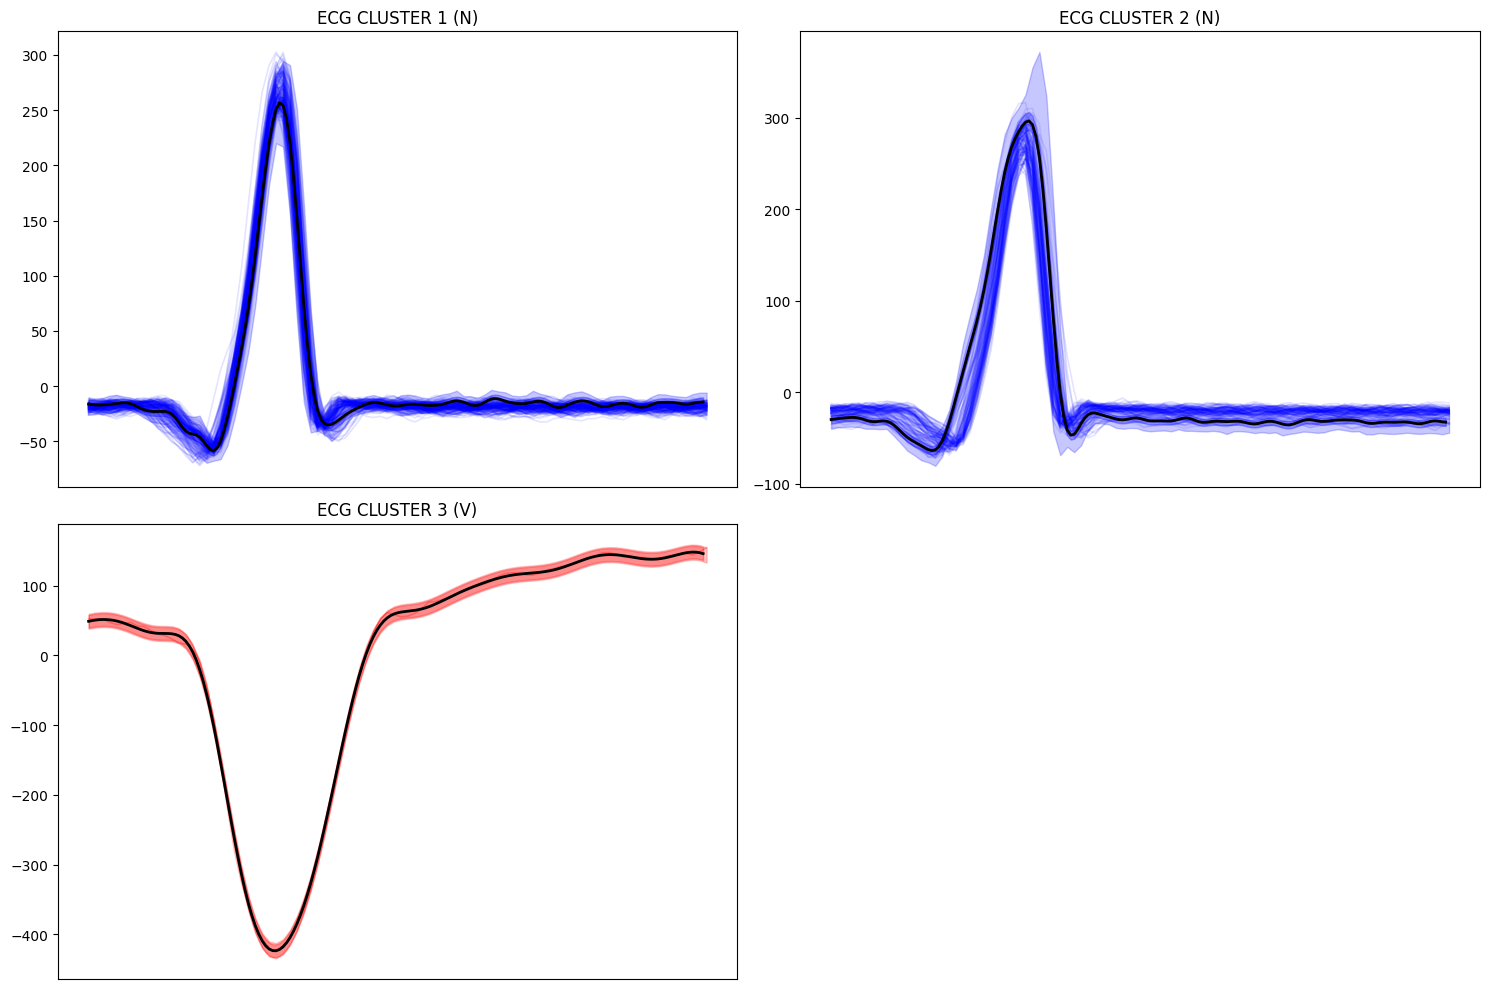

In [18]:
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

As expected, the ventricular beat generated a cluster itself.

To perform the same clustering but in an offline scheme, we only have to choose the offline inference method, we are going to use it with full record. Here are some new option parameters: reestimate_initial_params indicates when a reestimation for the prior LDS is desired (it is recommended in the offline setting), n_explore_steps indicates the number of tryals to generate a new group on each iteration, recommended is above 10, but in this case to make the clustering faster, 3 will be enough. This full clustering takes a bit longer.

In [19]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma_, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, reestimate_initial_params=True,
                          n_explore_steps=3)

data = np.load(os.path.join(data_path, '100.npy'))[:,:,[0]]
labels = np.load(os.path.join(data_path, '100_labels.npy'))
num_samples = data.shape[0]
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, data)


Redefining default LDS priors.
-----------Reestimated -----------
Sigma:  tensor(13.1431)
Gamma:  tensor(17.2435)
-----------------------------
Group responsability estimated: [2272    0]


Forward_pass:   0%|          | 0/2272 [00:00<?, ?it/s]


 Fitting_GP: 

Iter 1/4000 - Loss: 472.718
Iter 501/4000 - Loss: 29.155
Iter 1001/4000 - Loss: 21.011
Iter 1501/4000 - Loss: 17.216
Iter 2001/4000 - Loss: 14.863
Iter 2501/4000 - Loss: 13.199
Iter 3001/4000 - Loss: 11.928
Iter 3501/4000 - Loss: 10.908


Parameter name: likelihood.noise_covar.raw_noise           value = [4.36627432]
Parameter name: mean_module.raw_constant                   value = -0.49063280559376105
Parameter name: covar_module.raw_outputscale               value = 41.22618020052459
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[2.40026568]]


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 909.05it/s] 



-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1232.31it/s]


Step 1/3- Trying to divide: 0 with beat 1906


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 1016.08it/s]


Sum resp_temp: tensor([2.2710e+03, 1.0000e+00])
Q_bas: tensor(-123597.3276)
Q_bas_post: tensor(-123377.3683)
Chosen to divide: 0 with beat 1906
First resp: tensor([2.2710e+03, 1.0000e+00])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([2.2710e+03, 1.0000e+00])
ELBO_reduction: 0.0
Mean_sq: tensor(-123377.3683)
ELBO: tensor([-257837.3514])

-------Lower Bound Iteration 1-------
Group responsability estimated: [2271    1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1371.47it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------
Sum resp_temp: tensor([2.2710e+03, 1.0000e+00, 0.0000e+00])
Q_bas: tensor(-123377.3683)
Q_bas_post: tensor(-123377.3683)
Not reallocating, trying to generate new group.
Step 1/3- Trying to divide: 0 with beat 455


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1429.16it/s]


Sum resp_temp: tensor([2.1200e+03, 1.5100e+02, 1.0000e+00])
Q_bas: tensor(-123377.3683)
Q_bas_post: tensor(-122441.6995)
Chosen to divide: 0 with beat 455
First resp: tensor([2.1200e+03, 1.5100e+02, 1.0000e+00])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------
Current resp: tensor([2.1200e+03, 1.5100e+02, 1.0000e+00])
ELBO_reduction: 0.0
Mean_sq: tensor(-122441.6995)
ELBO: tensor([-255077.1418])

-------Lower Bound Iteration 2-------
Group responsability estimated: [2120  151    1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1532.00it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 1023.76it/s]



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1148.80it/s]



   -----------Model 3-----------

   -----------Model 4-----------
Sum resp_temp: tensor([1.6590e+03, 6.1200e+02, 1.0000e+00, 0.0000e+00])
Q_bas: tensor(-122441.6995)
Q_bas_post: tensor(-124416.8378)
Not reallocating, trying to generate new group.
Step 1/3- Trying to divide: 0 with beat 1938


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1209.17it/s]


Sum resp_temp: tensor([1.5280e+03, 4.8700e+02, 2.5600e+02, 1.0000e+00])
Q_bas: tensor(-122441.6995)
Q_bas_post: tensor(-122774.7103)
Step 2/3- Trying to divide: 0 with beat 1795


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1522.78it/s]


Sum resp_temp: tensor([1.5630e+03, 3.6100e+02, 3.4700e+02, 1.0000e+00])
Q_bas: tensor(-122441.6995)
Q_bas_post: tensor(-122433.4385)
Possibly better but no.
Step 3/3- Trying to divide: 0 with beat 1666


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1489.91it/s]


Sum resp_temp: tensor([1.5670e+03, 3.8700e+02, 3.1700e+02, 1.0000e+00])
Q_bas: tensor(-122441.6995)
Q_bas_post: tensor(-122464.1519)
First resp: tensor([2.1200e+03, 1.5100e+02, 1.0000e+00, 0.0000e+00])
Mean_sq: tensor(-122441.6995)
ELBO: tensor([-255077.0367])

-------Lower Bound Iteration 3-------


Now we can plot the results same as before:

Model 1 : MainModel: N : [A-31,N-2089]
Model 2 : MainModel: N : [A-2,N-149]
Model 3 : MainModel: V : [V-1]
Classification error:  33.0 / 2272 -- 0.014524647887323943


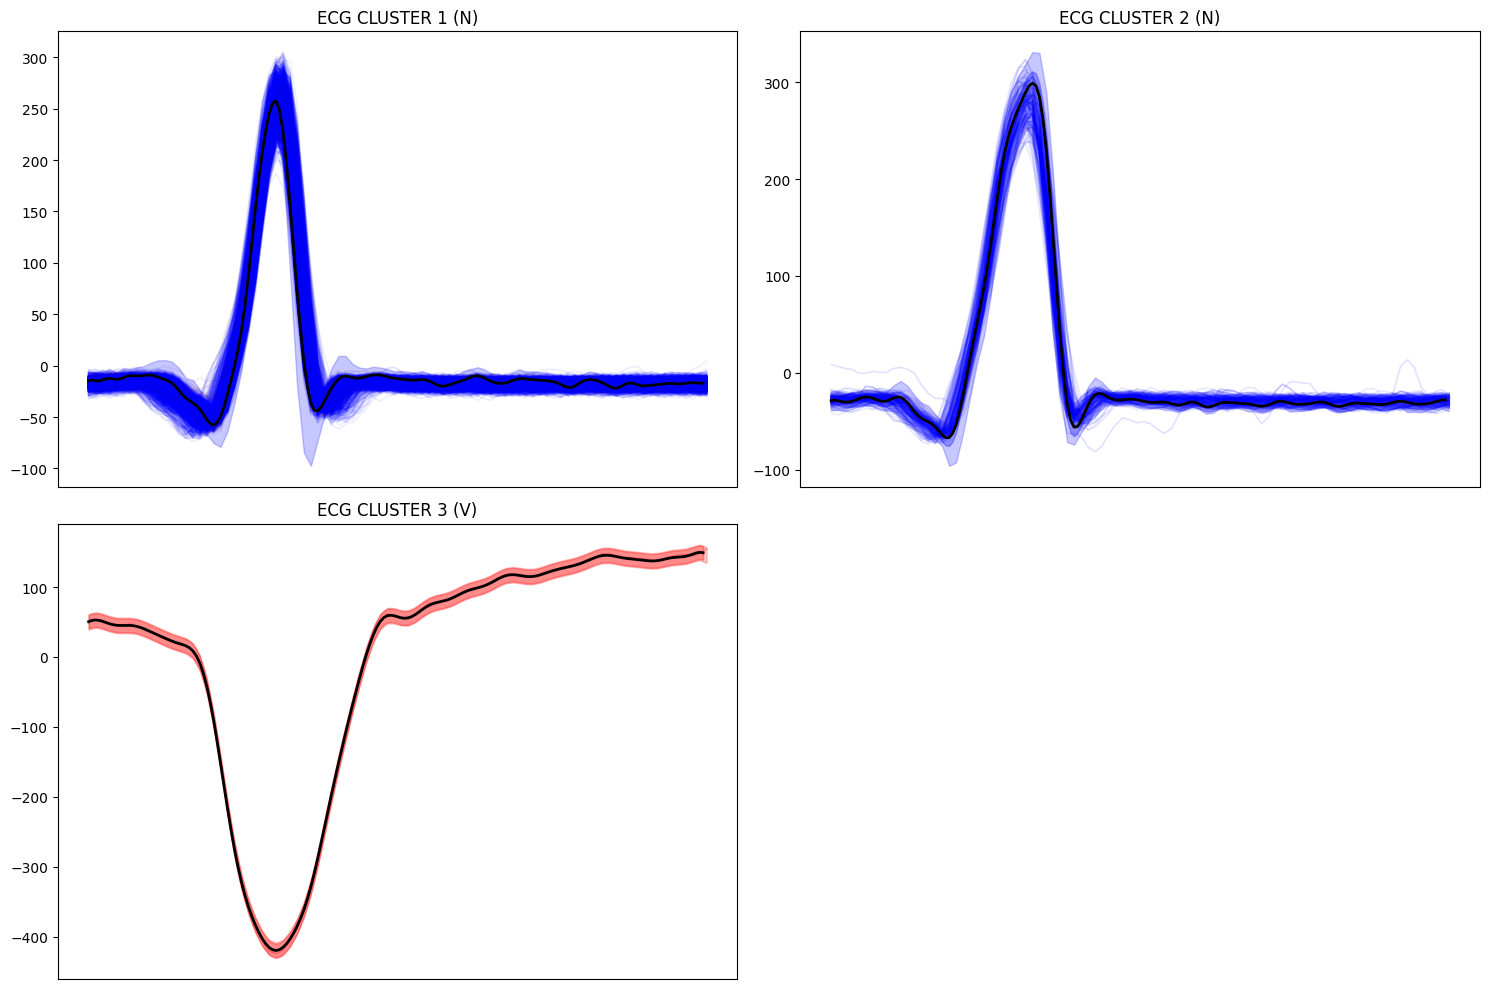

In [20]:
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

Of course, depending on the nature of the record to cluster, the hyperparameters can be tuned. First consideration should be focused on determining if the record is benefited of a dynamic clustering or not. In the case the patterns exhibit a dynamic change while remaining in the same category it will be interesting to priorize a dynamic behaviour, which is determined making $S_{\omega} > S_{\epsilon}$. If there exist different morphologies with patterns really close one to another, then it will be better to prioritize a static behaviour, with the opposite condition $S_{\omega} < S_{\epsilon}$. 

Once we have the clustering performed, there are parameters of the model which can lead us to interesting insights. For example, the transition matrix represent the probability of jumping from one cluster to another, which can be useful to detect some prevalent loops of behaviour.

In [21]:
sw_gp.compute_Pi()[:-1,:-1]


tensor([[9.3774e-01, 6.0243e-02, 2.5816e-04],
        [9.5801e-01, 3.0308e-02, 1.8525e-14],
        [9.7957e-01, 3.7454e-08, 3.2388e-14]])

Also, visualizing the dynamic parameters can be useful in some cases:

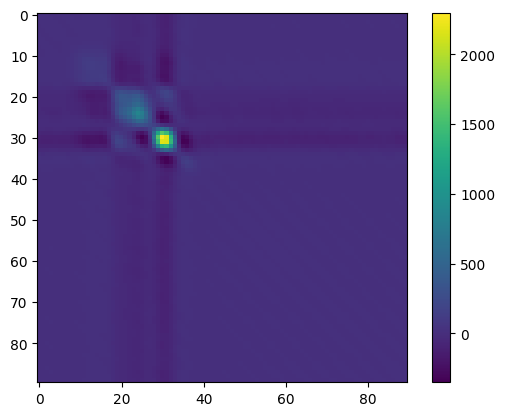

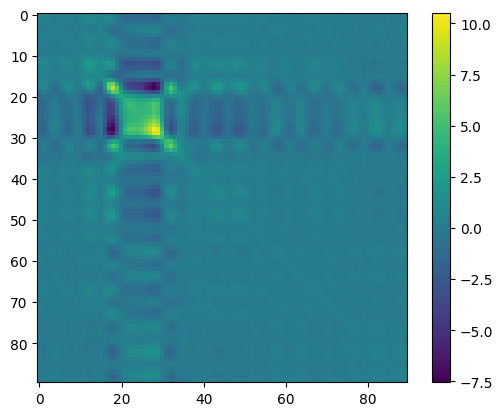

In [22]:
plt.imshow(sw_gp.gpmodels[0][0].Gamma[-1])
plt.colorbar()
plt.show()
plt.imshow(sw_gp.gpmodels[0][0].Sigma[-1])
plt.colorbar()
plt.show()

Usually, the dynamic transformation matrices $A, C$ are really close to the identity due to the conditions they have to satisfy (they have to be stable). So, sometimes is better to represent the transformation they produce in a vector of ones.

[]

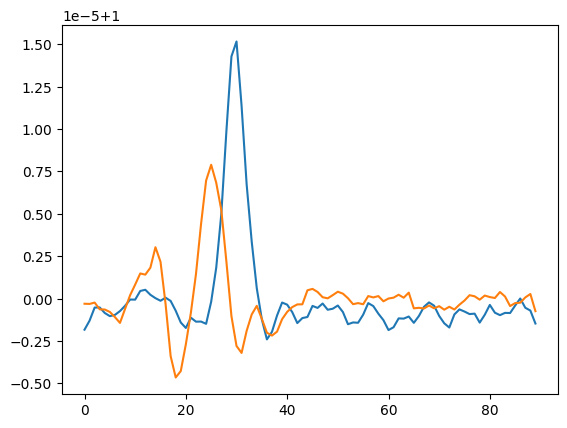

In [23]:
plt.plot(torch.matmul(sw_gp.gpmodels[0][0].A[-1], torch.ones(x_basis.shape[0])))
plt.plot(torch.matmul(sw_gp.gpmodels[0][1].A[-1], torch.ones(x_basis.shape[0])))
plt.plot()

Here we can see how even if the normality clusters seems really similar, the underlying dynamic transformation is really different. Also, we can use the Kullback-Leibler divergence to measure the similarity of the models during their evolution and then represent this distances using a MDS reduction.

Compute distance matrix.
Compute model 1
Compute model 2
Compute model 3
Calculando MDS para representación


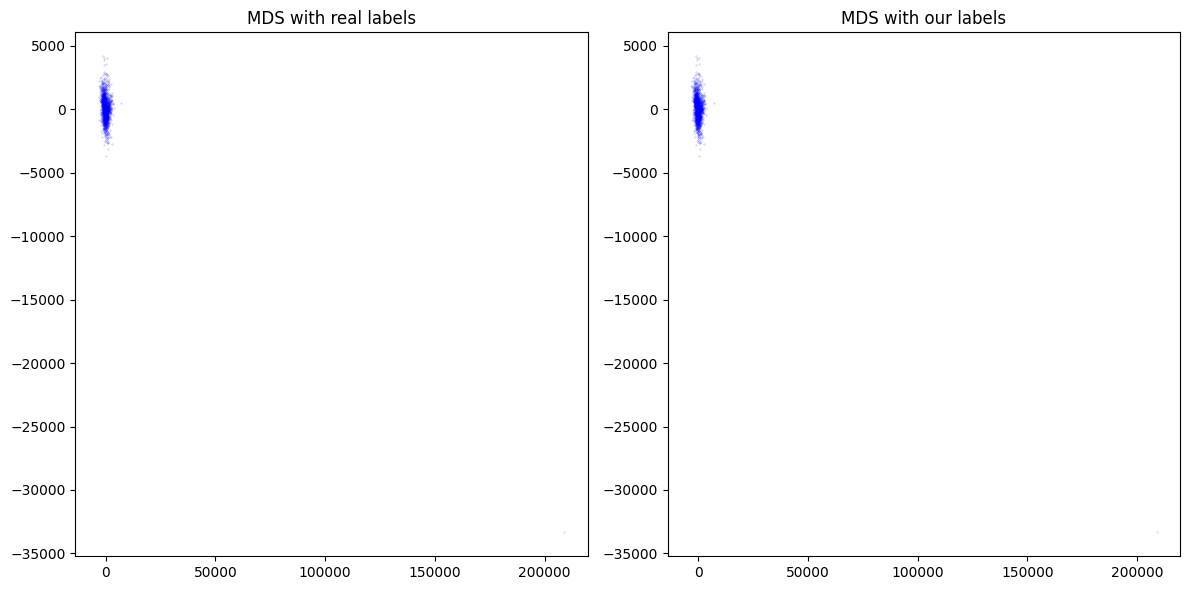

In [24]:
from hdpgpc.util_plots import plot_MDS_plotly
plot_MDS_plotly(sw_gp, main_model, labels, N_0=0, save=None)
plt.show()